In [1]:
############################ 0. PREPARATION ############################

#-------------------------- import packages --------------------------
# for data manipulation and EDA
import os
import random
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import pyreadr
import copy
from pathlib import Path
from matplotlib.image import imread

# scikitlearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.compose import make_column_transformer

# deep learning
import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Input, Multiply, Add, Embedding, Reshape, Concatenate, Dropout, BatchNormalization, Lambda, Conv2D, MaxPooling2D, Flatten, BatchNormalization, Rescaling
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras.losses import Poisson
import keras_tuner as kt
from keras.utils import plot_model, image_dataset_from_directory

# for fitting statistical model
import statsmodels.api as sm

# for suppress warnings
# Source: adapted from https://stackoverflow.com/questions/9031783/hide-all-warnings-in-ipython
import warnings
warnings.filterwarnings('ignore')

In [2]:
#-------------------------- import data --------------------------
data = pd.read_csv("exam_data.csv")
data.head()

,Age,Credit Score,Home Maintenance,Image Filename,Insured,Monthly Income,Previous Insurance Claims
0,54,601.440706,Occasionally,image_0000.jpg,1,5555.862913,1
1,52,677.621901,Frequently,image_0001.jpg,1,4175.986485,0
2,46,714.855922,Occasionally,image_0002.jpg,1,5809.415922,2
3,49,718.366077,Occasionally,image_0003.jpg,1,3673.591702,3
4,42,762.102195,Occasionally,image_0004.jpg,0,5554.626621,1


In [3]:
############################ 1. DATA UNDERSTANDING & CLEANING ############################

#-------------------------- high-level checking --------------------------
print(data.shape) # number of rows and columns
print(data.info()) # check data type and missing values

(3960, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3960 entries, 0 to 3959
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        3960 non-null   int64  
 1   Credit Score               3960 non-null   float64
 2   Home Maintenance           3960 non-null   object 
 3   Image Filename             3960 non-null   object 
 4   Insured                    3960 non-null   int64  
 5   Monthly Income             3960 non-null   float64
 6   Previous Insurance Claims  3960 non-null   int64  
dtypes: float64(2), int64(3), object(2)
memory usage: 216.7+ KB
None


In [4]:
# #-------------------------- convert Insured to the correct data type --------------------------
# data['Insured'] = data['Insured'].astype('category')

In [5]:
#-------------------------- descriptive statistics for numeric columns --------------------------
data[["Age","Credit Score","Monthly Income", "Previous Insurance Claims"]].describe()

,Age,Credit Score,Monthly Income,Previous Insurance Claims
count,3960.000000,3960.000000,3960.000000,3960.000000
mean,45.040152,674.357228,4749.298713,0.778283
std,5.055105,101.009643,1107.158536,0.917310
min,26.000000,282.583084,1486.868367,0.000000
25%,42.000000,599.617999,3929.065410,0.000000
50%,45.000000,692.272639,4739.817138,0.000000
75%,49.000000,751.763401,5574.187023,1.000000
max,62.000000,909.118925,8345.166460,3.000000


The range of values for Age, Credit Score, and Monthly Income is not consistent with what's described in the Ed Post. Need to check the distribution of these columns.

In [6]:
#-------------------------- initialize global variables --------------------------
all_vars = list(data.columns)
numeric_vars = ["Age","Credit Score","Monthly Income"]
cat_vars = ["Home Maintenance", "Previous Insurance Claims"]
target_var = "Insured"
image_folder = "images"
img_height = 224
img_width = 224

In [7]:
# #-------------------------- distribution of claims --------------------------
# # Count the occurrences of each unique value in "Previous Insurance Claims"
# claim_counts = data["Previous Insurance Claims"].value_counts().sort_index()
# claim_counts.index = claim_counts.index.astype(str) # treat claim counts in the plot like categories of a categorical variables - to make graph look nicer

# # Create the bar plot
# plt.figure(figsize = (10, 6)) # set the size of the figure
# plt.bar(claim_counts.index, claim_counts.values)
# plt.title(f"Distribution of Previous Claims")
# plt.xlabel('Claim Count')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()

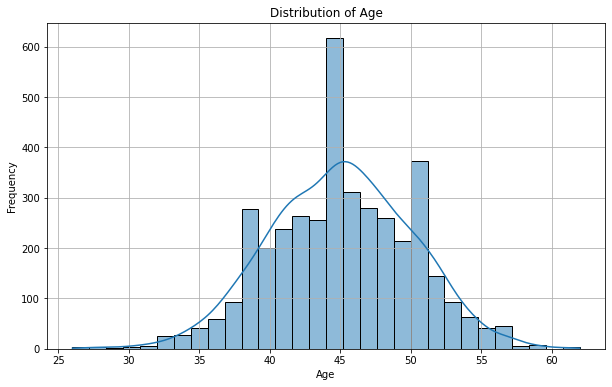

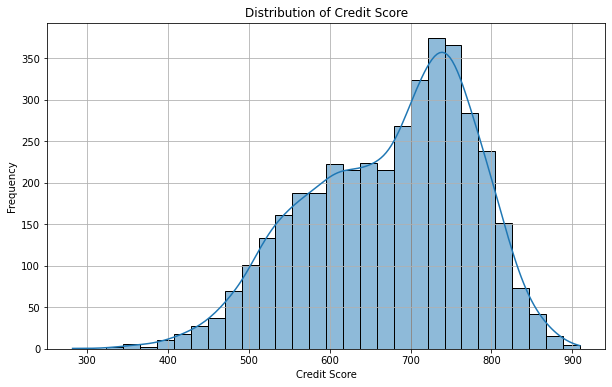

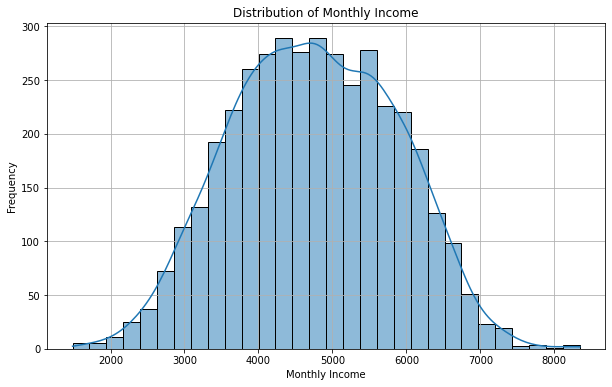

In [8]:
#-------------------------- distribution of numeric features --------------------------
for var in ["Age","Credit Score","Monthly Income"]:
    plt.figure(figsize = (10, 6)) # set the size of the figure
    sns.histplot(data[var], bins = 30, kde = True)
    plt.title(f"Distribution of {var}")
    plt.xlabel(f"{var}")
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()    

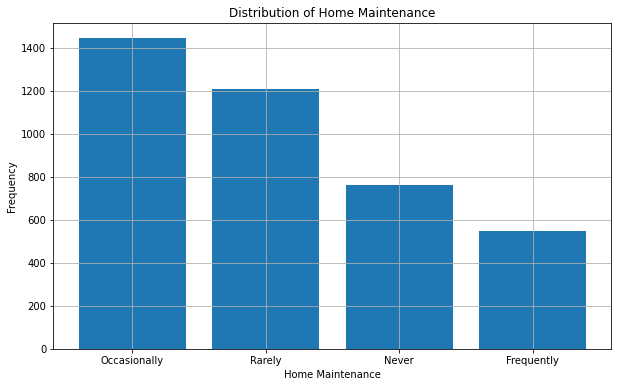

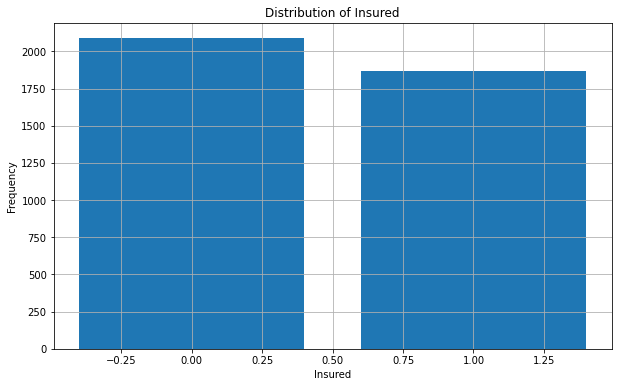

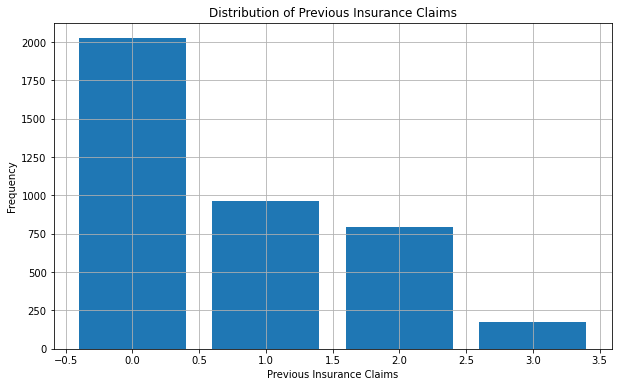

In [9]:
#-------------------------- distribution of categorical features --------------------------
for var in ["Home Maintenance","Insured","Previous Insurance Claims"]:

    # count the number of observations per category
    counts = data[var].value_counts()

    # draw the graph
    plt.figure(figsize = (10, 6)) # set the size of the figure
    plt.bar(counts.index, counts.values)
    plt.title(f"Distribution of {var}")
    plt.xlabel(f"{var}")
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()   

In [10]:
#-------------------------- check the size and number of images --------------------------
image_dimensions = [] # store the image size
for image in os.listdir(image_folder):
    img = imread(f"images/{image}")
    if img.shape not in image_dimensions:
        image_dimensions.append(img.shape)
print(f"Image size: {image_dimensions}")
print(f"Number of images: {len(os.listdir(image_folder))}")

In [ ]:
#-------------------------- check if the images of all observations are available --------------------------
all_images_name = os.listdir(image_folder)
sum(data["Image Filename"].map(lambda x: x in all_images_name)) == data.shape[0]

True

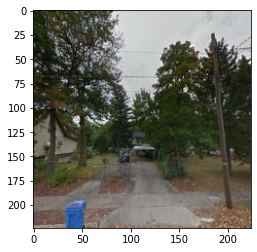

In [ ]:
#-------------------------- view a sample image --------------------------
plt.imshow(imread(f"images/{data['Image Filename'].iloc[0]}"))

In [ ]:
#-------------------------- train-test-split --------------------------
X_main, X_test, y_main, y_test = train_test_split(
    data.drop([target_var], axis = 1), data[[target_var]], test_size = 0.2, random_state = 1)
X_train, X_val, y_train, y_val = train_test_split(
    X_main, y_main, test_size = 0.25, random_state = 1)

#-------------------------- store image data in a separate object --------------------------


In [ ]:
def load_images(filenames):
    return np.array([imread(f"{image_folder}/{filename}") for filename in filenames])

img_train = load_images(X_train["Image Filename"])
img_val = load_images(X_val["Image Filename"])
img_test = load_images(X_test["Image Filename"])

In [ ]:
############################ 2. MODEL FITTING ############################

# define the architecture for a convolutional net
model_CNN = Sequential([
  Input((img_height, img_width, 3)),
  Rescaling(1./255),
  Conv2D(15, 3, padding = "same", activation="relu", name="conv1"),
  MaxPooling2D(name="pool1", pool_size = 2),
  Conv2D(15, 3, padding = "same", activation="relu", name="conv2"),
  MaxPooling2D(name="pool2", pool_size = 2),
  Conv2D(15, 3, padding = "same", activation="relu", name="conv3"),
  MaxPooling2D(name="pool3", pool_size=2),
  Flatten(),
  Dense(128, activation="relu"),
  Dense(2, activation = "sigmoid")
])

# get a summary of the model
print(model_CNN.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 224, 224, 15)      420       
                                                                 
 pool1 (MaxPooling2D)        (None, 112, 112, 15)      0         
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 15)      2040      
                                                                 
 pool2 (MaxPooling2D)        (None, 56, 56, 15)        0         
                                                                 
 conv3 (Conv2D)              (None, 56, 56, 15)        2040      
                                                                 
 pool3 (MaxPooling2D)        (None, 28, 28, 15)       

In [ ]:
# compile and fit
es = EarlyStopping(patience = 5, restore_best_weights = True, verbose = 0)
model_CNN.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy",
    metrics = ["accuracy"])
model_CNN.fit(img_train, y_train, callbacks = [es], epochs = 50, validation_data = (img_val, y_val))

Epoch 1/50
75/75 [==============================] - 21s 281ms/step - loss: 0.7264 - accuracy: 0.4832 - val_loss: 0.6930 - val_accuracy: 0.5227
Epoch 2/50
75/75 [==============================] - 20s 272ms/step - loss: 0.6930 - accuracy: 0.5152 - val_loss: 0.6926 - val_accuracy: 0.5227
Epoch 3/50
75/75 [==============================] - 20s 268ms/step - loss: 0.6928 - accuracy: 0.5152 - val_loss: 0.6924 - val_accuracy: 0.5227
Epoch 4/50
75/75 [==============================] - 20s 268ms/step - loss: 0.6926 - accuracy: 0.5152 - val_loss: 0.6921 - val_accuracy: 0.5227
Epoch 5/50
75/75 [==============================] - 20s 267ms/step - loss: 0.6930 - accuracy: 0.5139 - val_loss: 0.6919 - val_accuracy: 0.5227
Epoch 6/50
75/75 [==============================] - 20s 268ms/step - loss: 0.6923 - accuracy: 0.5152 - val_loss: 0.6912 - val_accuracy: 0.5227
Epoch 7/50
75/75 [==============================] - 20s 269ms/step - loss: 0.6905 - accuracy: 0.5383 - val_loss: 0.6892 - val_accuracy: 0.5215